# Анализ временного ряда

> Для корректной работы ссылок оглавления лучше смотреть проект здесь \
> https://nbviewer.org/github/experiment0/sf_data_science/blob/main/project_11/time_series.ipynb

**Оглавление**<a id='toc0_'></a>    
- [Описание задачи](#toc1_)    
- [Загрузка данных](#toc2_)    
- [Исследование ряда](#toc3_)    
  - [Декомпозиция временного ряда](#toc3_1_)    
  - [Определение порядка интегрирования ряда](#toc3_2_)    
  - [Автокорреляция и частичная автокорреляция](#toc3_3_)    
- [Гетерокседастичность и волатильность ряда](#toc4_)    
- [Прогнозирование значений ряда](#toc5_)    
  - [SARIMA](#toc5_1_)    
    - [Подбор параметров с помощью pmdarima](#toc5_1_1_)    
  - [Prophet](#toc5_2_)    
  - [Построение прогноза для отложенной валидационной выборки](#toc5_3_)    
- [Выводы](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Описание задачи](#toc0_)

Будем исследовать временной ряд с данными о продажах в сфере розничной торговли и общественного питания в США за 1992-2025 гг., представленных по месяцам.

Далее сделаем предсказание для последних 12 месяцев ряда.

В качестве метрики качества возьмем среднюю абсолютную ошибку в процентах — MAPE (Mean Absolute Percent Error),

$$ MAPE = \sum_{i=1}^{n} \frac{\left | y_{i} - \hat{y_{i}} \right |}{\left | y_{i} \right |} \frac{100\%}{n} $$

## <a id='toc2_'></a>[Загрузка данных](#toc0_)

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from prophet import Prophet
from matplotlib import pyplot as plt

from utils.prepare_data import get_splitted_data
from utils.graphics import (
    display_corelogram, 
    display_prediction,
)
from utils.heplers import (
    display_mape, 
    get_mape_in_percent,
    check_time_series_stationarity,
)

%matplotlib inline 

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Загрузим данные
data = pd.read_csv(
    './data/retail_trade_and_food_services.csv',
    parse_dates=['per_name'],
    index_col='per_name',
)

data.head()

,val
per_name,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


**Описание столбцов:**

- `per_name` - временной период (год и месяц)
- `val` - сумма продаж в сфере розничной торговли и общественного питания в США в млн. $ США.

Убедимся, что столбцы имеют правильный тип.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 396 entries, 1992-01-01 to 2024-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   val     396 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


Индекс представлен в формате `datetime`, значение в формате `float`. \
Всего в таблице 396 записей. Пропусков нет.\
То есть, данные корректные.

## <a id='toc3_'></a>[Исследование ряда](#toc0_)

In [4]:
print(
    'Данные представлены за период с',
    str(data.index.min()),
    'по',
    str(data.index.max()),
)


Данные представлены за период с 1992-01-01 00:00:00 по 2024-12-01 00:00:00


Посмотрим, как данные выглядят на графике.

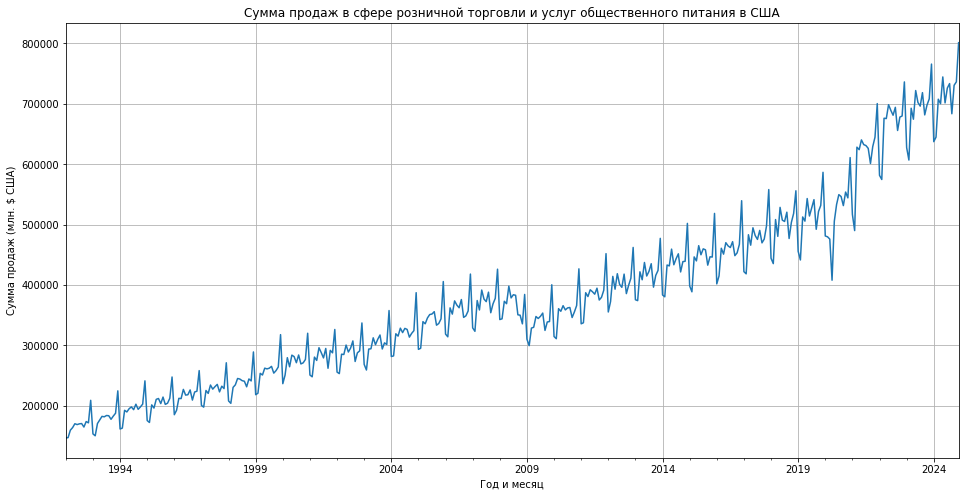

In [5]:
data.plot(
    figsize=(16, 8),
    title='Сумма продаж в сфере розничной торговли и услуг общественного питания в США',
    xlabel='Год и месяц',
    ylabel='Сумма продаж (млн. $ США)',
    grid=True,
    legend=False,
);

На первый взгляд видны возрастающий тренд и сезонность. \
Также со временем увеличивается разброс в значениях ряда.

Разделим выборку на тренировочную, тестовую и валидационную.\
На тренировочной выборке будем исследовать ряд и обучать модель.\
Тестовую используем для поиска лучших параметров модели.\
А на валидационной посмотрим на результат предсказания.

In [6]:
train_data, test_data, valid_data = get_splitted_data(data)

print('train_data size:', train_data.shape)
print('test_data size:', test_data.shape)
print('valid_data size:', valid_data.shape)

train_data size: (372, 1)
test_data size: (12, 1)
valid_data size: (12, 1)


### <a id='toc3_1_'></a>[Декомпозиция временного ряда](#toc0_)

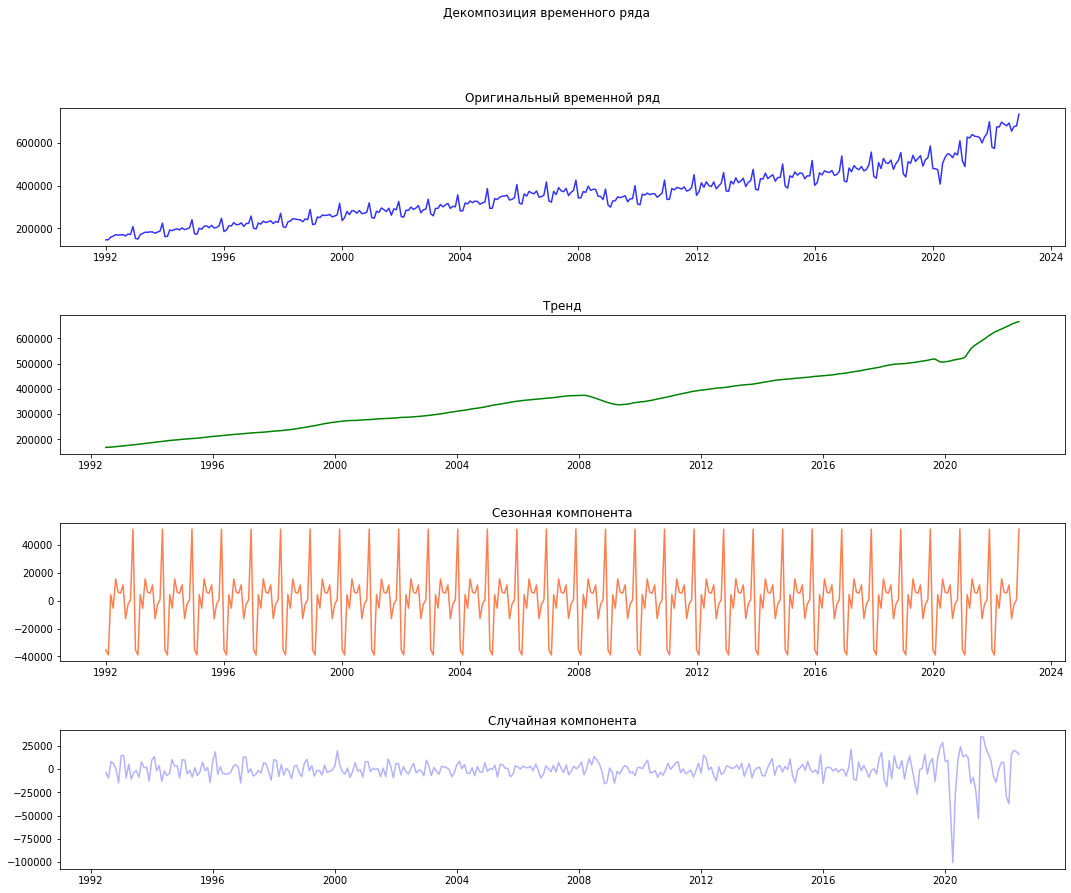

In [7]:
# Производим декомпозицию временного ряда 
decomposition = seasonal_decompose(train_data, model='additive')

# Строим графики составляющих
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(18, 14))
plt.subplots_adjust(hspace=.5)

axs[0].plot(train_data, color='blue', alpha=0.8)
axs[0].set_title('Оригинальный временной ряд')

axs[1].plot(decomposition.trend, color='green')
axs[1].set_title('Тренд')

axs[2].plot(decomposition.seasonal, color='coral')
axs[2].set_title('Сезонная компонента')

axs[3].plot(decomposition.resid, color='blue', alpha=0.3)
axs[3].set_title('Случайная компонента')

plt.suptitle(f'Декомпозиция временного ряда')
plt.show()

Есть возрастающий тренд, сезонность и шум.\
У шумовой компоненты после 2020 г наблюдается резкое изменение амплитуды колебаний.\
Возможно, это связано с уменьшением продаж из-за COVID-19.

В файл [years_plot.ipynb](./years_plot.ipynb) вынесено построение графиков продаж за отдельные года.\
И вывод о тенденциях продаж в разные месяцы.\
Здесь продублируем выводы:

- в данных есть годовая сезонность;
- продажи ниже в январе-феврале;
- в течение года наблюдается их рост;
- наибольшее количество продаж приходится на декабрь;
- в сентябре идет спад продаж по сравнению с августом.

Посмотрим на первые 37 значений сезонной компоненты.

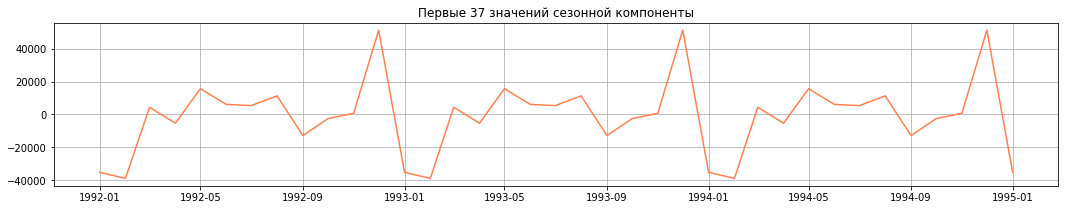

In [8]:
fig, ax = plt.subplots(figsize=(18, 3))

ax.plot(decomposition.seasonal[:37], color='coral')
ax.grid()
ax.set_title('Первые 37 значений сезонной компоненты');

Видно, что график повторяется через каждые 12 месяцев.\
Построим график со скользящим средним в 12 месяцев.

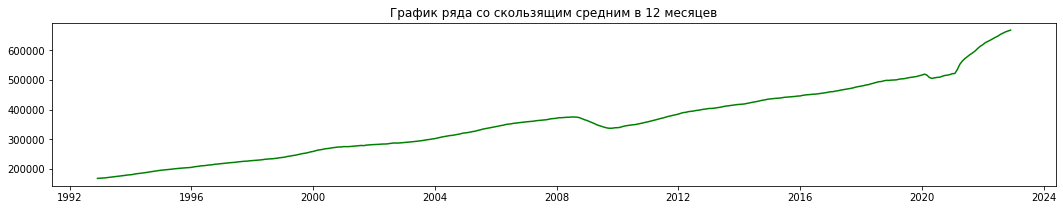

In [9]:
fig, ax = plt.subplots(figsize=(18, 3))

ax.plot(train_data.val.rolling(window=12).mean(), color='green')
ax.set_title('График ряда со скользящим средним в 12 месяцев');

График повторяет компоненту тренда выше.

### <a id='toc3_2_'></a>[Определение порядка интегрирования ряда](#toc0_)

По графику выше видно, что у ряда есть тренд и сезонность, значит он не является стационарным.\
Определим его порядок интегрирования.

Для этого будем дифференцировать ряд до приведения его к стационарному.

Для проверки ряда на стационарность воспользуемся [расширенным тестом Дики-Фуллера](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).\
В тесте формулируются две гипотезы:

- **Нулевая гипотеза** ($H_0$): \
временной **ряд нестационарный**, то есть имеет некоторый тренд и/или сезонную компоненту;

- **Альтернативная гипотеза** ($H_1$): \
временной **ряд стационарный**, то есть не имеет тренда и сезонной компоненты.

Выберем уровень значимости 5%.

- Если значение статистики **ниже** критического уровня значимости, \
**отвергаем гипотезу $H_0$** и принимаем гипотезу $H_1$ (**ряд стационарный**).

- Если значение статистики **выше** критического  уровня значимости, \
**принимаем гипотезу $H_0$** (**ряд нестационарный**).

Код для определения стационарности ряда вынесен в функцию `check_time_series_stationarity` в файл [utils/heplers.py](./utils/heplers.py)

In [10]:
# Убедимся, что исходный ряд нестационарный
check_time_series_stationarity(train_data)

Значение статистики теста: 1.4943883242121045
p-value: 0.9975034468558998
Критические значения разных уровней значимости:
    1%: -3.448905534655263
    5%: -2.8697161816205705
    10%: -2.5711258103550882
Значение статистики 1.4943883242121045 больше выбранного уровня значимости значимости 5%.
У нас нет оснований отвергнуть нулевую гипотезу, РЯД НЕ СТАЦИОНАРНЫЙ.


In [11]:
# Дифференцируем ряд
diff_train_data = train_data.diff().dropna()

# Проверим дифференцированный ряд на стационарность
check_time_series_stationarity(diff_train_data)

Значение статистики теста: -3.4793180929390295
p-value: 0.008534410012290475
Критические значения разных уровней значимости:
    1%: -3.4489583388155194
    5%: -2.869739378430086
    10%: -2.5711381780459
Значение статистики -3.4793180929390295 меньше выбранного уровня значимости 5%.
Отвергаем нулевую гипотезу, РЯД СТАЦИОНАРНЫЙ.


После первого дифференцирования ряда мы привели его к стационарному.\
Значит порядок интегрирования нашего ряда равен 1.

Посмотрим на график ряда после дифференцирования.

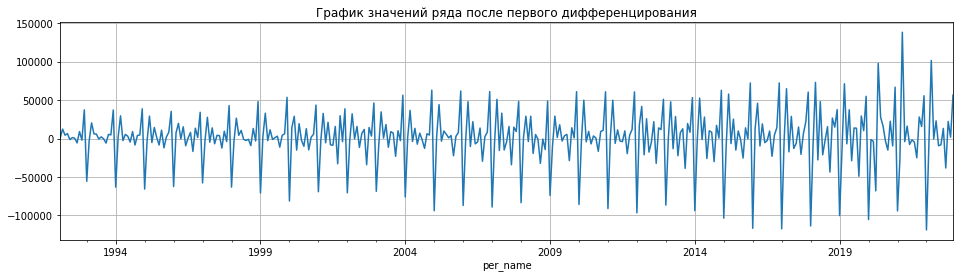

In [12]:
diff_train_data.plot(
    figsize=(16, 4),
    title='График значений ряда после первого дифференцирования',
    grid=True,
    legend=False,
);

Дифференцированный ряд похож на стационарный.\
Тренда не наблюдается, но есть повторяемость в колебаниях.\
Посмотрим на график первых и последних значений дифференцированного ряда.

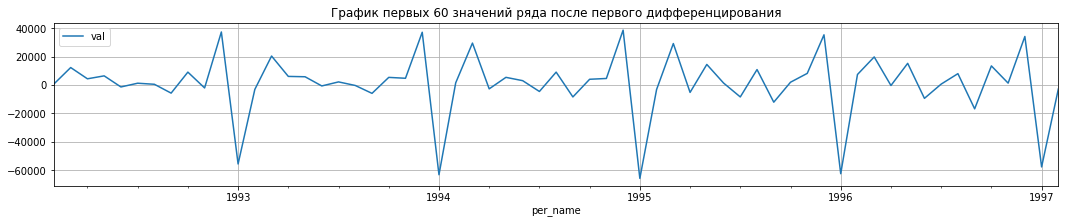

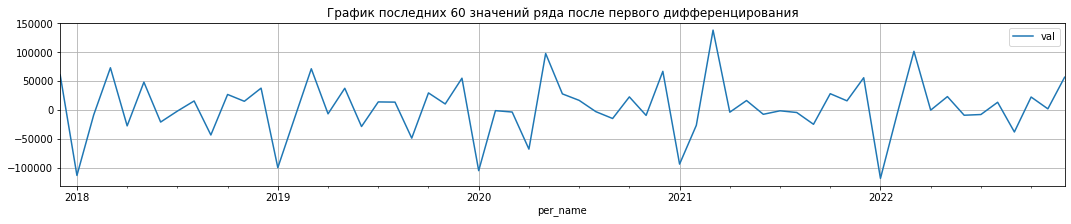

In [13]:
diff_train_data[:61].plot(    
    figsize=(18, 3),
    title='График первых 60 значений ряда после первого дифференцирования',
    grid=True,
);
diff_train_data[-61:].plot(
    figsize=(18, 3),
    title='График последних 60 значений ряда после первого дифференцирования',
    grid=True,
);

В данных прослеживается повторяемость колебаний в течение года.\
Если провести эксперимент и дифференцировать ряд еще несколько раз, подобная повторяемость останется.\
Поэтому остановимся на первом дифференцировании.

Для иллюстрации посмотрим на график первых значений ряда после 12-го дифференцирования.

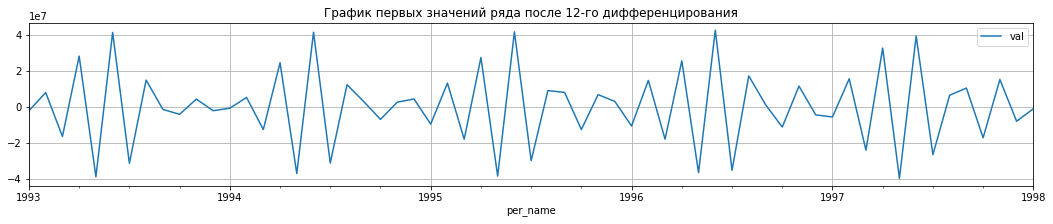

In [14]:
diff_n_train_data = diff_train_data
for i in range(1, 12):
    diff_n_train_data = diff_n_train_data.diff().dropna()
    
diff_n_train_data[:61].plot(    
    figsize=(18, 3),
    title='График первых значений ряда после 12-го дифференцирования',
    grid=True,
);

На графике продолжает прослеживаться повторяемость колебаний в течение года.\
Поэтому остановимся на первом дифференцировании.

### <a id='toc3_3_'></a>[Автокорреляция и частичная автокорреляция](#toc0_)

Построим графики автокорреляции и частичной автокорреляции для дифференцированного ряда.

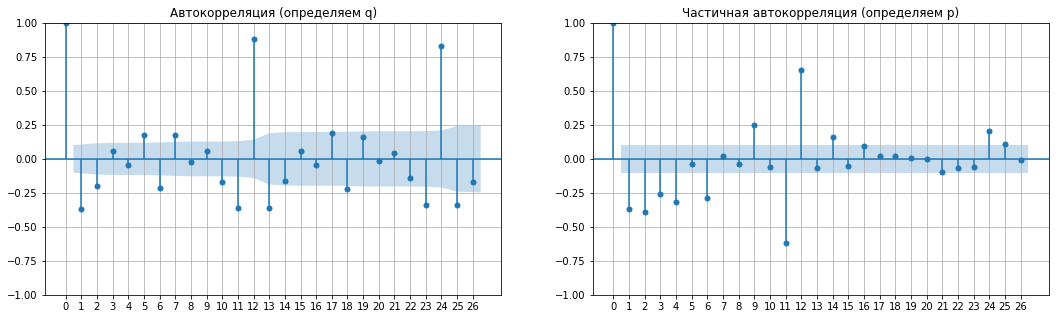

In [16]:
display_corelogram(diff_train_data)

На графике автокорреляции сильно выдается 12-й лаг (и затем 24-й).\
Временной ряд содержит циклическую компоненту с периодом 12.\
То есть, значения коррелируют между собой через каждые 12 месяцев.

На графике частичной автокорреляции больше других выделяются 11-й и 12-й лаги.

## <a id='toc4_'></a>[Гетерокседастичность и волатильность ряда](#toc0_)

Исследование ряда на предмет гетерокседастичности и построение прогноза для волатильности вынесено отдельный в файл [volatility.ipynb](./volatility.ipynb) для удобства чтения по причине его объема.

## <a id='toc5_'></a>[Прогнозирование значений ряда](#toc0_)

Сделаем прогноз значений ряда для тестовой выборки.\
Выберем лучшую модель и проверим итоговый результат на валидационной.

Поскольку ряд не является стационарным и у него есть тренд и сезонная составляющая, используем модель `SARIMA`.

### <a id='toc5_1_'></a>[SARIMA](#toc0_)

Для построения прогноза используем модель [SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).\
Модель `SARIMAX` отличается от `SARIMA` тем, что может использовать для предсказания экзогенные параметры.\
Если не передавать экзогенные параметры в `SARIMAX`, то она будет работать как `SARIMA`.

В модель передается параметр `order`.\
Его состав такой же, как для модели `ARIMA` \
(`ARIMA` отличается от `SARIMA` тем, что не использует сезонную составляющую).\
В `order` входят три параметра:
- `p` - количество авторегрессионных слагаемых (определяется по графику частичной автокорреляции);
- `d` - порядок интегрирования ряда;
- `q` - количество слагаемых скользящего среднего шумовой компоненты (определяется по графику автокорреляции).

Чтобы использовать сезонную составляющую, передадим порядок сезонности -\
`seasonal_order` с сезонными параметрами:

- `P` — сезонный авторегрессионный порядок;
- `D` — порядок дифференцирования сезонного ряда;
- `Q` — порядок сезонной скользящей средней;
- `m` — размер сезонного периода.

Подберем параметры с помощью библиотеки [pmdarima](http://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima).

#### <a id='toc5_1_1_'></a>[Подбор параметров с помощью pmdarima](#toc0_)

In [18]:
# %%script echo skipping

# Метод auto_arima позволяет перебрать несколько значений по сетке
# и по критерию выбрать наилучшие параметры для модели.
smodel = pm.auto_arima(
    # Датафрейм с временным рядом
    train_data, 
    
    # Диапазон параметров для order
    d=1,
    start_p=1, max_p=12,
    start_q=1, max_q=12,
    
    # Диапазон параметров для seasonal_order
    start_P=1, max_P=12,
    D=1,
    start_Q=1, max_Q=12,
    m=12,
    
    seasonal=True,
    test='adf',
    error_action='ignore',
    trace=True,
    n_jobs=-1,
    maxiter=100,
    random_state=42,
)

# Выводим итоговые параметры модели
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=7832.083, Time=0.60 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7914.855, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7876.952, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=7849.233, Time=0.21 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=7838.598, Time=0.39 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=7861.889, Time=0.34 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=7830.717, Time=1.16 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=7848.442, Time=0.92 sec
 ARIMA(1,1,1)(3,1,1)[12]             : AIC=7826.356, Time=2.70 sec
 ARIMA(1,1,1)(3,1,0)[12]             : AIC=7832.406, Time=1.87 sec
 ARIMA(1,1,1)(4,1,1)[12]             : AIC=7826.444, Time=4.69 sec
 ARIMA(1,1,1)(3,1,2)[12]             : AIC=7821.639, Time=3.77 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=7823.080, Time=2.77 sec
 ARIMA(1,1,1)(4,1,2)[12]             : AIC=7821.664, Time=7.90 sec
 ARIMA(1,1,1)(3,1,3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  372
Model:             SARIMAX(0, 1, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood               -3891.299
Date:                                    Sun, 06 Apr 2025   AIC                           7798.598
Time:                                            17:36:06   BIC                           7829.665
Sample:                                        01-01-1992   HQIC                          7810.952
                                             - 12-01-2022                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0949      0.026     -3.639      0.000      -0.146      -0.044
ma.L2         -0.2352      0.034     -6.993      0.000      -0.301      -0.169
ar.S.L12       0.8563      0.103      8.332      0.000       0.655       1.058
ar.S.L24      -0.8783      0.075    -11.756      0.000      -1.025      -0.732
ma.S.L12      -1.3540      0.109    -12.421      0.000      -1.568      -1.140
ma.S.L24       1.1781      0.130      9.039      0.000       0.923       1.434
ma.S.L36      -0.3564      0.056     -6.375      0.000      -0.466      -0.247
sigma2       1.94e+08   3.26e-09   5.95e+16      0.000    1.94e+08    1.94e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              8858.84
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               3.28   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.79e+32. Standard errors may be unstable.
"""

Обучим модель с лучшими найденными параметрами.

In [19]:
# Создаем объект модели 
sarima_model = SARIMAX(
    train_data, 
    order=(0, 1, 2), 
    seasonal_order=(2, 1, 3, 12),
)

# Обучаем
sarima_model_fitted = sarima_model.fit()

# Выводим критерии модели
sarima_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                        val   No. Observations:                  372
Model:             SARIMAX(0, 1, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood               -3891.299
Date:                                    Sun, 06 Apr 2025   AIC                           7798.598
Time:                                            17:48:28   BIC                           7829.665
Sample:                                        01-01-1992   HQIC                          7810.952
                                             - 12-01-2022                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0949      0.026     -3.639      0.000      -0.146      -0.044
ma.L2         -0.2352      0.034     -6.993      0.000      -0.301      -0.169
ar.S.L12       0.8563      0.103      8.332      0.000       0.655       1.058
ar.S.L24      -0.8783      0.075    -11.756      0.000      -1.025      -0.732
ma.S.L12      -1.3540      0.109    -12.421      0.000      -1.568      -1.140
ma.S.L24       1.1781      0.130      9.039      0.000       0.923       1.434
ma.S.L36      -0.3564      0.056     -6.375      0.000      -0.466      -0.247
sigma2       1.94e+08   3.26e-09   5.95e+16      0.000    1.94e+08    1.94e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):              8858.84
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               3.28   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.79e+32. Standard errors may be unstable.
"""

In [20]:
# Получим предсказание
predict = sarima_model_fitted.predict(
    start=len(train_data), 
    end=(len(train_data)+len(test_data)-1), 
    dynamic=False
)

# Посчитаем MAPE для нашего предсказания
sarima_mape = get_mape_in_percent(test_data, predict)
display_mape(test_data, predict)

Метрика MAPE: 1.86 %


Получим значения доверительных интервалов для построения графиков.

In [21]:
# Метод get_forecast мы можем использовать для получения доверительного интервала,
# то есть верхней и нижней границы, которые позволят нам полагать, что
# наше значение должно быть примерно в этом диапазоне
forecast = sarima_model_fitted.get_forecast(len(test_data.index))

# alpha=0.05 означает уровень доверия 95%
# Это значит, что мы будем считать, что наше значение попадет в этот интервал 
# с вероятностью 0.95
forecast_data = forecast.conf_int(alpha=0.05)

# Посмотрим на полученную таблицу с данными доверительных интервалов
forecast_data

,lower val,upper val
2023-01-01,600635.445855,655238.451360
2023-02-01,581941.950774,655588.364951
2023-03-01,667277.710330,749507.010725
2023-04-01,648416.961391,738414.302288
2023-05-01,681593.634229,778739.837963
2023-06-01,667301.507368,771105.401484
2023-07-01,661291.132155,771350.715890
2023-08-01,671180.558185,787158.898896
2023-09-01,629782.080405,751391.451220
2023-10-01,652413.864701,779404.819638


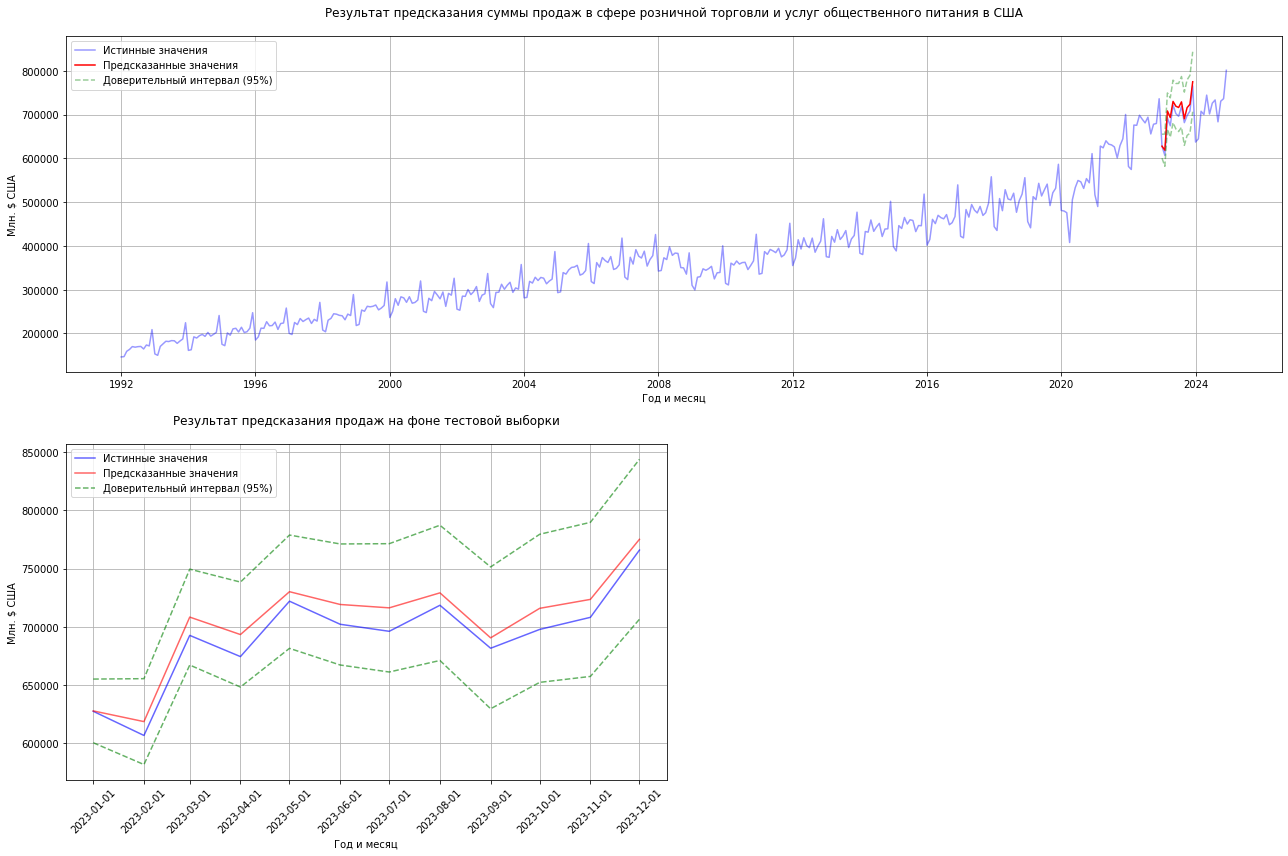

In [22]:
# Отобразим предсказание на графике
display_prediction(data, test_data, predict, forecast_data)

Прогноз проходит довольно близко от графика.\
Модель уловила тенденцию изменений.

### <a id='toc5_2_'></a>[Prophet](#toc0_)

[Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) — библиотека с открытым исходным кодом, выпущенная командой Facebook Core Data Science.\
(*Facebook принадлежит компании Meta, признанной экстремистской организацией и запрещенной в РФ*).

В модель нужно передавать таблицу с двумя колонками.\
В колонке `ds` должны находится даты, а в колонке `y` - значения.\
Подготовим таблицу для передачи в модель.

In [42]:
prophet_data = data.copy().reset_index().rename(
    columns={'per_name': 'ds', 'val': 'y'}
)
prophet_data.head()

,ds,y
0,1992-01-01,146376.0
1,1992-02-01,147079.0
2,1992-03-01,159336.0
3,1992-04-01,163669.0
4,1992-05-01,170068.0


In [43]:
# Разделим выборку на обучающую и тестовую
train_prophet_data, test_prophet_data, valid_prophet_data = get_splitted_data(prophet_data)

print('train_prophet_data size:', train_prophet_data.shape)
print('test_prophet_data size:', test_prophet_data.shape)
print('valid_prophet_data size:', valid_prophet_data.shape)

train_prophet_data size: (372, 2)
test_prophet_data size: (12, 2)
valid_prophet_data size: (12, 2)


In [44]:
# Создаем объект модели
prophet_model = Prophet(yearly_seasonality=True)

# Обучаем модель
prophet_model.fit(train_prophet_data)

# Получаем предсказание
prophet_predict = prophet_model.predict(test_prophet_data[['ds']])

# Посмотрим, как выглядит таблица с предсказанием
prophet_predict

18:02:28 - cmdstanpy - INFO - Chain [1] start processing
18:02:28 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-01,647750.158361,588433.979006,637092.724795,647750.158361,647750.158361,-36735.582030,-36735.582030,-36735.582030,-36735.582030,-36735.582030,-36735.582030,0.0,0.0,0.0,611014.576331
1,2023-02-01,650363.723311,587519.796970,634893.551714,650363.723311,650363.723311,-38650.224763,-38650.224763,-38650.224763,-38650.224763,-38650.224763,-38650.224763,0.0,0.0,0.0,611713.498548
2,2023-03-01,652724.362620,629096.648347,677079.059569,652724.090671,652724.362620,586.406763,586.406763,586.406763,586.406763,586.406763,586.406763,0.0,0.0,0.0,653310.769383
3,2023-04-01,655337.927570,628263.321532,675557.075595,655284.836963,655363.917759,-3524.343957,-3524.343957,-3524.343957,-3524.343957,-3524.343957,-3524.343957,0.0,0.0,0.0,651813.583613
4,2023-05-01,657867.183973,647625.748677,696814.411322,657740.392136,657934.199875,15043.162080,15043.162080,15043.162080,15043.162080,15043.162080,15043.162080,0.0,0.0,0.0,672910.346053
5,2023-06-01,660480.748922,640049.515518,687119.399877,660257.668490,660605.622984,3554.390534,3554.390534,3554.390534,3554.390534,3554.390534,3554.390534,0.0,0.0,0.0,664035.139456
6,2023-07-01,663010.005325,643467.921278,691347.372694,662689.627883,663238.934026,4550.121240,4550.121240,4550.121240,4550.121240,4550.121240,4550.121240,0.0,0.0,0.0,667560.126565
7,2023-08-01,665623.570275,656040.978518,702636.107193,665177.745278,665963.182700,13051.758806,13051.758806,13051.758806,13051.758806,13051.758806,13051.758806,0.0,0.0,0.0,678675.329080
8,2023-09-01,668237.135224,629314.873679,677705.527955,667680.664347,668699.655330,-14840.707652,-14840.707652,-14840.707652,-14840.707652,-14840.707652,-14840.707652,0.0,0.0,0.0,653396.427572
9,2023-10-01,670766.391627,643961.528513,693365.540185,670106.611111,671355.209217,-3132.269214,-3132.269214,-3132.269214,-3132.269214,-3132.269214,-3132.269214,0.0,0.0,0.0,667634.122413


В столбце `yhat` содержится предсказание.\
В столбцах `yhat_lower` и `yhat_upper` - нижняя и верхняя границы доверительного интервала.

Посчитаем значение метрики `MAPE` для полученного предсказания.

In [51]:
prophet_mape = get_mape_in_percent(test_prophet_data['y'].values, prophet_predict['yhat'].values)
display_mape(test_prophet_data['y'], prophet_predict['yhat'])

Метрика MAPE: 4.37 %


Метрика хуже, чем полученная с помощью модели `SARIMA`.

Подготовим данные для построения графика прогноза.

In [52]:
# Таблица с данными для построения графика 
# (для корректной работы функции построения графика в индексе должны содержаться даты)
prophet_graph_data = prophet_predict.set_index('ds')

# Выделим в отдельную таблицу данные с доверительными интервалами
prophet_forecast = prophet_graph_data[['yhat_lower', 'yhat_upper']]
prophet_forecast.head()

,yhat_lower,yhat_upper
ds,,
2023-01-01,588433.979006,637092.724795
2023-02-01,587519.796970,634893.551714
2023-03-01,629096.648347,677079.059569
2023-04-01,628263.321532,675557.075595
2023-05-01,647625.748677,696814.411322


In [53]:
# Переименуем столбцы, чтобы передать таблицу с доверительными интервалами в функцию построения графика
prophet_forecast.rename(
    columns={'yhat_lower': 'lower val', 'yhat_upper': 'upper val'},
    inplace=True,
)
prophet_forecast.head()

,lower val,upper val
ds,,
2023-01-01,588433.979006,637092.724795
2023-02-01,587519.796970,634893.551714
2023-03-01,629096.648347,677079.059569
2023-04-01,628263.321532,675557.075595
2023-05-01,647625.748677,696814.411322


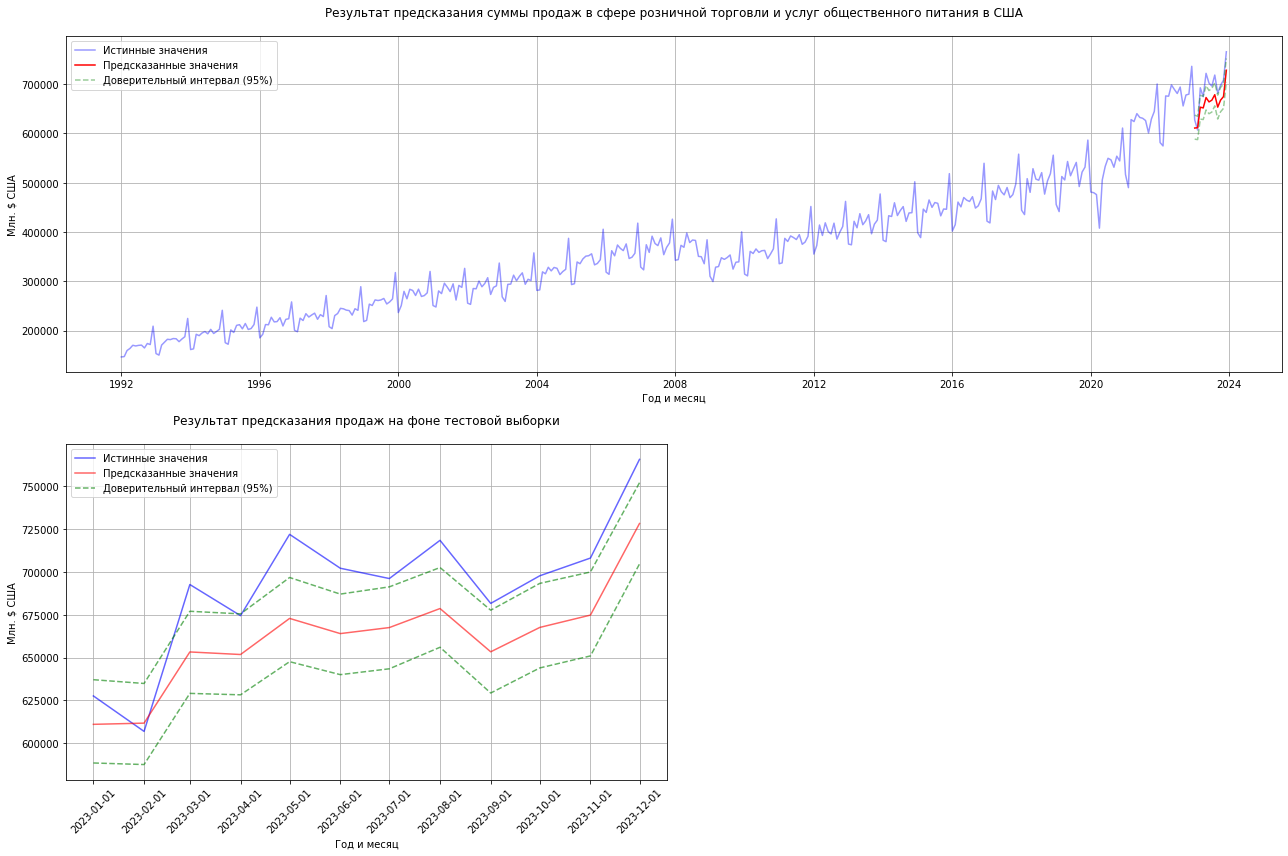

In [56]:
# Отобразим предсказание на графике
display_prediction(
    pd.concat([train_data, test_data]), 
    test_data, 
    prophet_graph_data['yhat'], 
    prophet_forecast,
)

График прогноза прогноза расположен ниже, чем истинные значения.\
И истинные значения в большинстве своем не попадают в доверительный интервал.\
Хотя линию графика истинных значений прогноз повторяет.\
Модель уловила тенденцию, но точность лучше у модели `SARIMA`.

Воспользуемся методом `plot_components` и посмотрим на компоненты ряда.

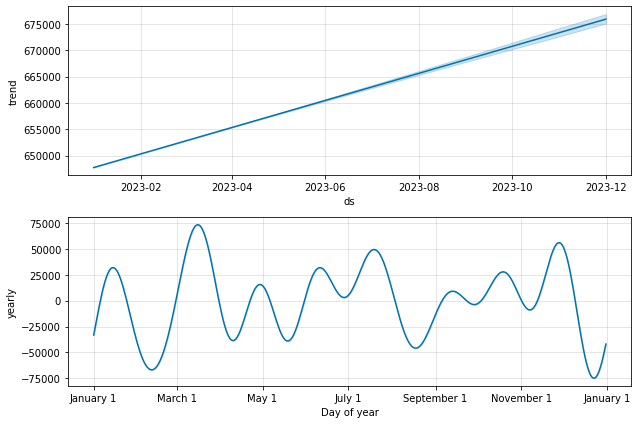

In [39]:
fig = prophet_model.plot_components(prophet_predict)


Модель обнаружила тренд и годовую сезонность.

### <a id='toc5_3_'></a>[Построение прогноза для отложенной валидационной выборки](#toc0_)

Мы использовали две модели, `SARIMA` и `Prophet`, и получили следующие метрики `MAPE`.

In [57]:
print(f'SARIMA MAPE: {round(sarima_mape, 4)} %', )
print(f'Prophet MAPE: {round(prophet_mape, 4)} %', )

SARIMA MAPE: 1.86 %
Prophet MAPE: 4.37 %


По значению метрики `MAPE` и приближению графика с предсказанием к истинным значениям лучше справилась модель `SARIMA`.\
Поэтому используем ее для предсказания для валидационной выборки.

In [58]:
# Создаем объект модели 
sarima_model = SARIMAX(
    pd.concat([train_data, test_data]), 
    order=(0, 1, 2), 
    seasonal_order=(2, 1, 3, 12),
)

# Обучаем
sarima_model_fitted = sarima_model.fit()

# Выводим критерии модели
sarima_model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                        val   No. Observations:                  384
Model:             SARIMAX(0, 1, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood               -4017.745
Date:                                    Sun, 06 Apr 2025   AIC                           8051.491
Time:                                            18:16:27   BIC                           8082.820
Sample:                                        01-01-1992   HQIC                          8063.934
                                             - 12-01-2023                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0953      0.026     -3.668      0.000      -0.146      -0.044
ma.L2         -0.2341      0.034     -6.952      0.000      -0.300      -0.168
ar.S.L12       0.8544      0.098      8.725      0.000       0.662       1.046
ar.S.L24      -0.8724      0.072    -12.178      0.000      -1.013      -0.732
ma.S.L12      -1.3603      0.105    -12.910      0.000      -1.567      -1.154
ma.S.L24       1.1741      0.126      9.320      0.000       0.927       1.421
ma.S.L36      -0.3500      0.056     -6.277      0.000      -0.459      -0.241
sigma2      1.926e+08   3.01e-09    6.4e+16      0.000    1.93e+08    1.93e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              9222.28
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               3.20   Skew:                             1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.18e+31. Standard errors may be unstable.
"""

In [60]:
# Получим предсказание
predict = sarima_model_fitted.predict(
    start=len(pd.concat([train_data, test_data])), 
    end=(len(data)-1), 
    dynamic=False
)

# Посчитаем MAPE для нашего предсказания
sarima_valid_mape = get_mape_in_percent(valid_data, predict)
display_mape(valid_data, predict)

Метрика MAPE: 1.78 %


Получим значения доверительных интервалов для построения графиков.

In [62]:
# Метод get_forecast мы можем использовать для получения доверительного интервала,
# то есть верхней и нижней границы, которые позволят нам полагать, что
# наше значение должно быть примерно в этом диапазоне
forecast = sarima_model_fitted.get_forecast(len(valid_data.index))

# alpha=0.05 означает уровень доверия 95%
# Это значит, что мы будем считать, что наше значение попадет в этот интервал 
# с вероятностью 0.95
forecast_data = forecast.conf_int(alpha=0.05)

# Посмотрим на полученную таблицу с данными доверительных интервалов
forecast_data

,lower val,upper val
2024-01-01,632169.903037,686575.798353
2024-02-01,604475.741710,677844.496836
2024-03-01,677511.773611,759453.778970
2024-04-01,650333.885446,740033.440942
2024-05-01,699747.195844,796584.834559
2024-06-01,682590.068001,786074.589975
2024-07-01,680930.696646,790660.201823
2024-08-01,692633.067096,808270.787269
2024-09-01,651625.581574,772883.984806
2024-10-01,673064.178269,799694.026199


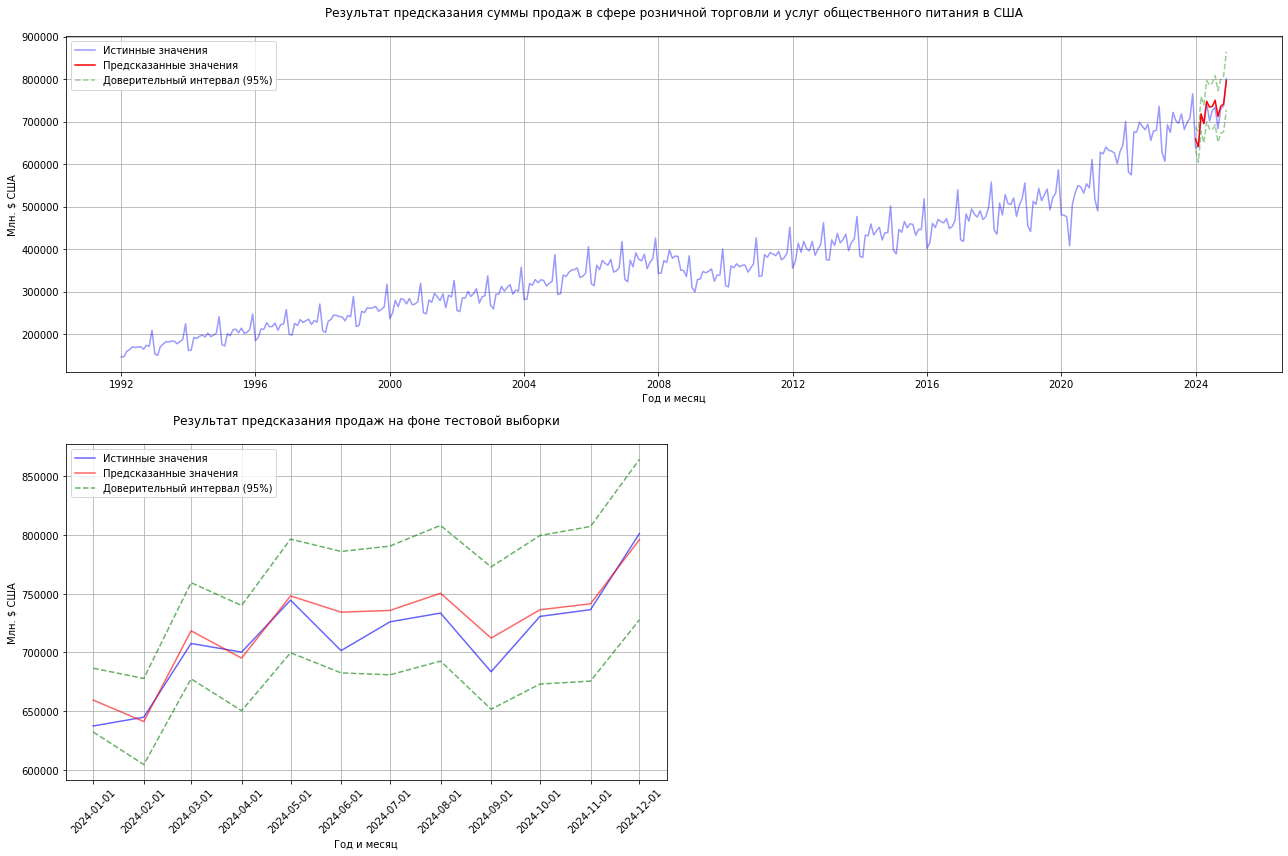

In [63]:
# Отобразим предсказание на графике
display_prediction(data, valid_data, predict, forecast_data)

Предсказание проходит довольно близко к графику истинных значений.\
Истинные значения попадают в доверительные интервалы.\
Метрика MAPE получилась даже лучше, чем на тестовой выборке.

In [66]:
print(f'MAPE модели SARIMA на тестовой выборке: {round(sarima_mape, 2)} %')
print(f'MAPE модели SARIMA на отложенной валидационной выборке: {round(sarima_valid_mape, 2)} %')

MAPE модели SARIMA на тестовой выборке: 1.86 %
MAPE модели SARIMA на отложенной валидационной выборке: 1.78 %


## <a id='toc6_'></a>[Выводы](#toc0_)

На рассматриваемых тренировочных и тестовых данных более лучший результат по метрике `MAPE` показала модель `SARIMA`.

In [67]:
print(f'MAPE для модели SARIMA: {round(sarima_mape, 2)} %')
print(f'MAPE для модели Prophet: {round(prophet_mape, 2)} %')

MAPE для модели SARIMA: 1.86 %
MAPE для модели Prophet: 4.37 %


Для отложенных валидационных данных модель `SARIMA` показала значение метрики:

In [68]:
print(f'MAPE: {round(sarima_valid_mape, 2)} %')

MAPE: 1.78 %


Что даже лучше, чем на тестовой.\
То есть, модель `SARIMA` уловила тенденцию изменения данных во временном ряду.

Но нужно отметить, что для модели `Prophet` не требуется долго подбирать внешние параметры и возможно, ей просто не хватило данных для обучения.